# Module 5 - Spooky Authorship Identification
#### Group 13
- Aidan Lonergan
- Daniel Lillard
- Radhika Garg
- Claudine Uwiragiye

<hr>

### Objective
1) Accurately identify the author of the sentences in the test set
2) Perform all work with Apache Spark

<hr>

### Stage 0 - Import Data
1) Create a code notebook called: code_6_of_10_data_mine_group13.ipynb
2) Load the dataset into Spark data objects and explore structure, size, and distribution of information

In [1]:
# Stage 0 Solution
from pyspark.sql import SparkSession
import pandas as pd

# Start spark session and load train and test data sets
spark = SparkSession.builder.appName("Module_5_Project").getOrCreate()
df_train = spark.read.csv('./train.csv', header=True, inferSchema=True, quote='"', escape='"')

##### Summary

In [2]:
# Print size and descriptive statistics
print("==== DataSet Shape ====")
print(f"{len(df_train.columns)} columns\n{df_train.count()} rows\n")

print("==== DataSet Descriptive Statistics ====")
print(df_train.describe().show())

print("\n==== DataSet Unique Authors ====")
print(df_train.select('author').distinct().show())

==== DataSet Shape ====
3 columns
19579 rows

==== DataSet Descriptive Statistics ====
+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NULL|                NULL|  NULL|
|    min|id00001|" Odenheimer, res...|   EAP|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+

None

==== DataSet Unique Authors ====
+------+
|author|
+------+
|   MWS|
|   HPL|
|   EAP|
+------+

None


<hr>

### Stage 1 - Data Preparation (Exploratory data analysis and text mining pre-processing)
1) Perform exploratory data analysis and create visualizations and tables as needed
2) Text Preprocessing: perform tasks like tokenization and stopwords removal to clean text data
    - Tokenize - split the text into individual words aka tokens.
    - Remove stop.words - frequently used pronouns and personal references.
        - Top ten include: I, you, he, she, it, we, they, me, him, her
    - Lemmatization - convert words to their root (optional).
        - Lemmatization is a text normalization technique that reduces words to their base or dictionary form (lemma). Use to reduce inflected or derived words to their root form for better analysis and modeling outcomes

In [3]:
# Step 1 - Preprocessing
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, split, explode, length, lower, regexp_replace, count, row_number
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Get stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Clean and lowercase text, remove punctuation
df_train_cleaned = df_train.withColumn("clean_text", lower(regexp_replace(col("text"), r"[^a-zA-Z0-9\s]", "")))

# Tokenize into words then filter out empty strings after tokenization
df_train_words = df_train_cleaned.withColumn("word", explode(split(col("clean_text"), r"\s+"))).filter(col('word') != "")

# Remove stop words
df_train_filtered = df_train_words.filter(~col("word").isin(stop_words))

df_train_filtered.show(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aflon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+-------+--------------------+------+--------------------+------------+
|     id|                text|author|          clean_text|        word|
+-------+--------------------+------+--------------------+------------+
|id26305|This process, how...|   EAP|this process howe...|     process|
|id26305|This process, how...|   EAP|this process howe...|     however|
|id26305|This process, how...|   EAP|this process howe...|    afforded|
|id26305|This process, how...|   EAP|this process howe...|       means|
|id26305|This process, how...|   EAP|this process howe...|ascertaining|
|id26305|This process, how...|   EAP|this process howe...|  dimensions|
|id26305|This process, how...|   EAP|this process howe...|     dungeon|
|id26305|This process, how...|   EAP|this process howe...|       might|
|id26305|This process, how...|   EAP|this process howe...|        make|
|id26305|This process, how...|   EAP|this process howe...|     circuit|
+-------+--------------------+------+--------------------+------

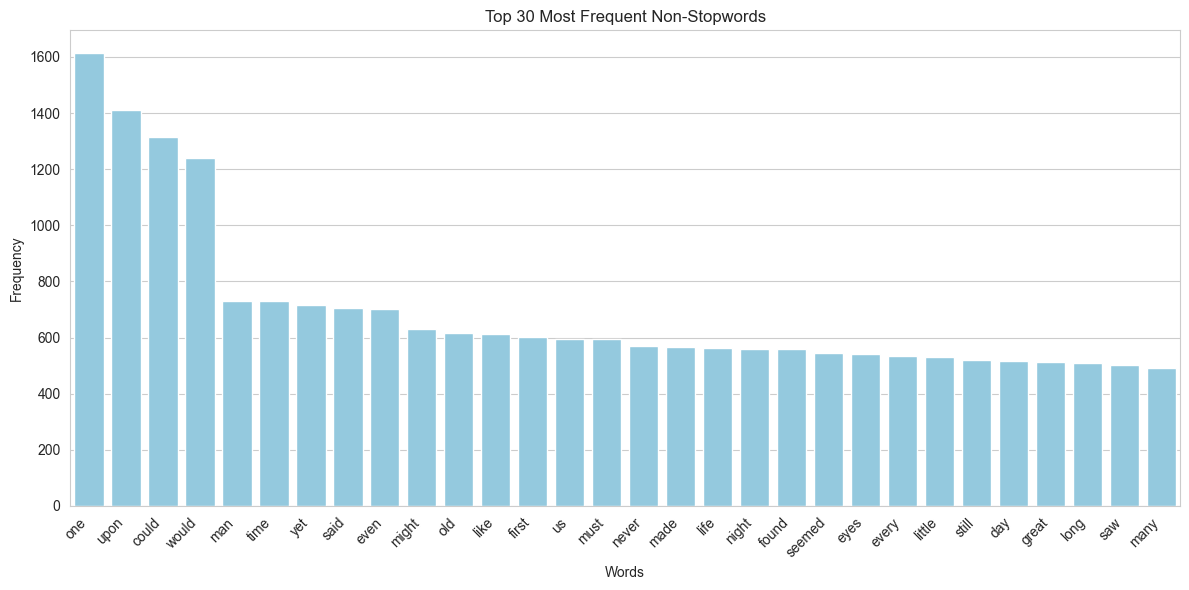

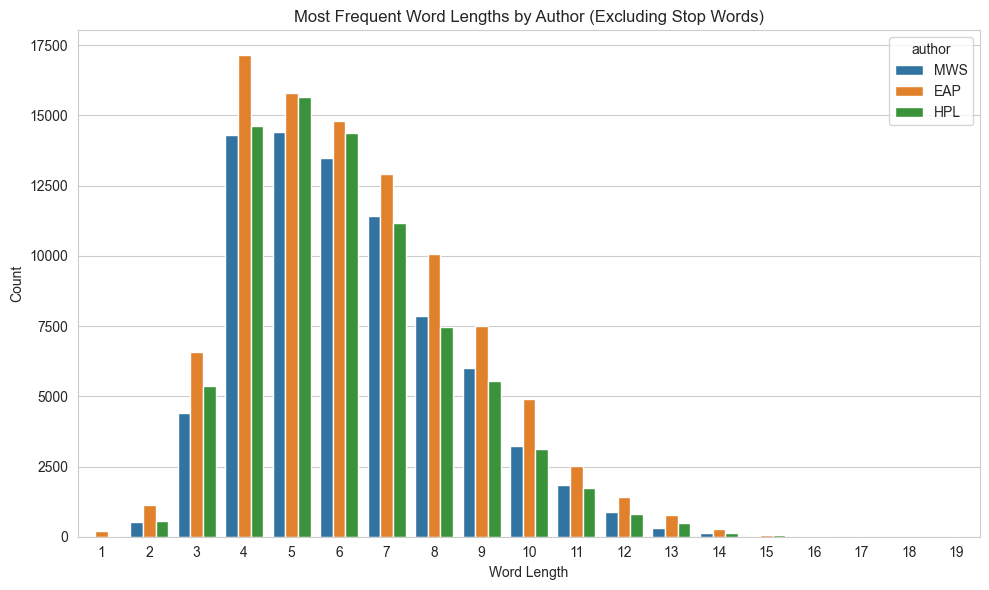

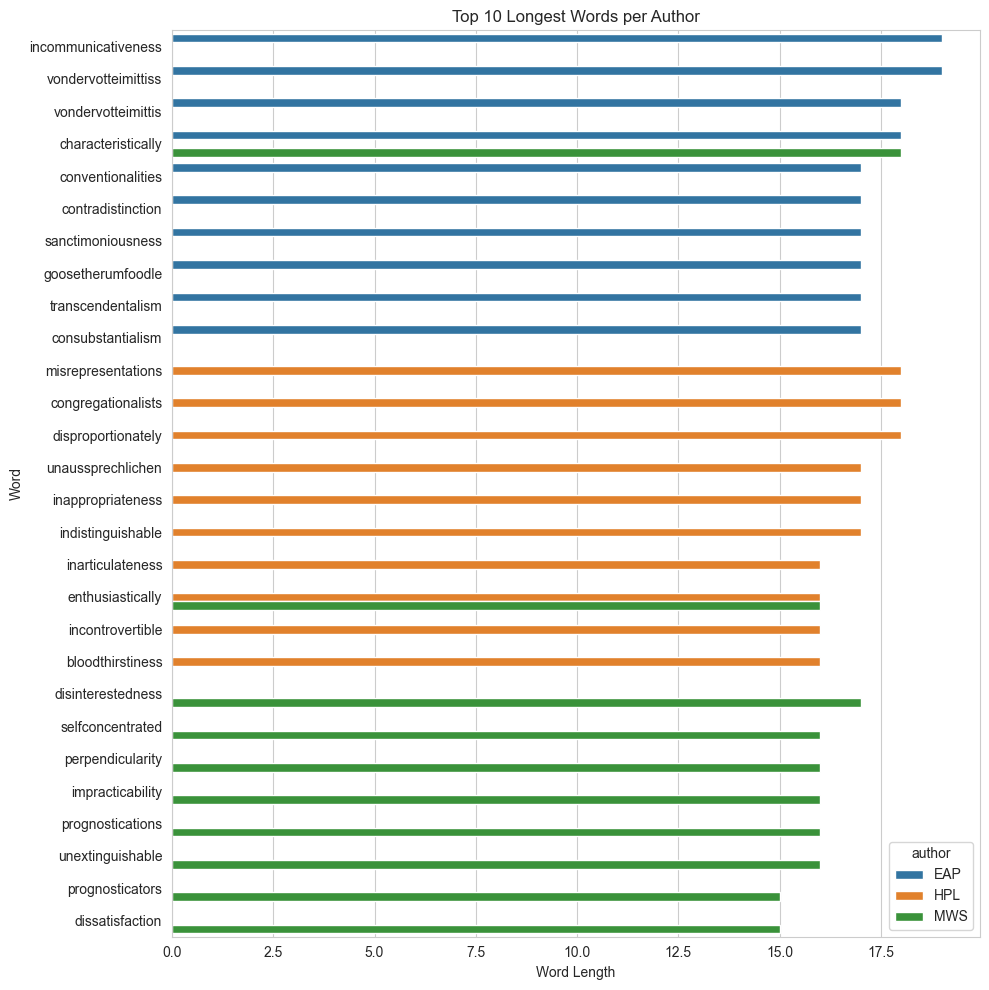

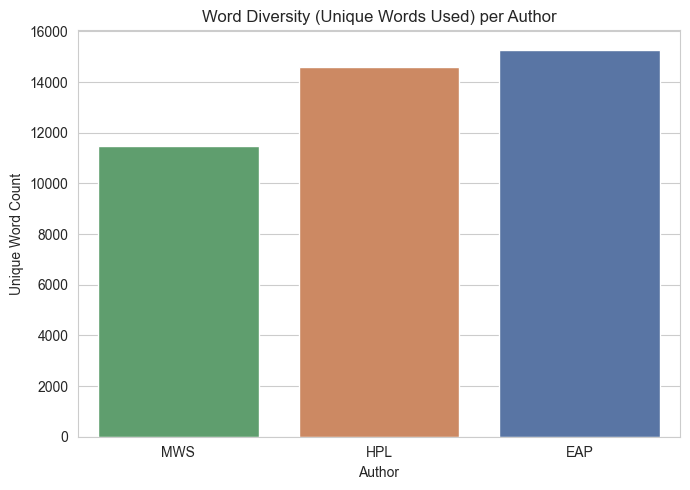

In [4]:
# Stage 1 Analysis and Visualizations
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ---------- CHART 1: Most Frequent Word Lengths ----------
# Get word frequency
df_word_freq = df_train_filtered.groupBy("word").agg(count("*").alias("frequency"))

# Get top 30 most frequent words
df_top_words = df_word_freq.orderBy(col("frequency").desc()).limit(30)

# Convert to pandas for sns
pdf_top_words = df_top_words.toPandas()

# Plot Chart 1
plt.figure(figsize=(12, 6))
sns.barplot(data=pdf_top_words, x="word", y="frequency", color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top 30 Most Frequent Non-Stopwords")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---------- CHART 2: Most Frequent Word Lengths ----------
# Get word lengths
df_word_lengths = df_train_filtered.withColumn("length", length(col("word")))

# Group by author and length, then count occurrences
df_grouped = df_word_lengths.groupBy("author", "length").agg(count("*").alias("count"))

# Convert to pandas for sns
pdf_word_lengths = df_grouped.toPandas()

# Plot chart 2
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf_word_lengths, x="length", y="count", hue="author")
plt.title("Most Frequent Word Lengths by Author (Excluding Stop Words)")
plt.xlabel("Word Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- CHART 3: Top 10 Longest Words per Author ----------
# Group by author and word, get length of word
df_longest = df_word_lengths.groupBy("author", "word") \
    .agg(count("*").alias("count"),
    F.max(length(col('word'))).alias('length')
)

# Rank words by length within each author
windowSpec = Window.partitionBy("author").orderBy(col("length").desc())

# Get top 10 words per author
df_top_longest = df_longest.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") <= 10)

# Convert to pandas for sns
pdf_longest = df_top_longest.select("author", "word", "length").toPandas()

# Plot chart 3
plt.figure(figsize=(10, 10))
sns.barplot(data=pdf_longest, x="length", y="word", hue="author")
plt.title("Top 10 Longest Words per Author")
plt.xlabel("Word Length")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# ----- CHART 4: count unique words by author ----------
# Get unique words per author
df_unique_words = df_train_filtered.select("author", "word").distinct()

# Count the unique words per author
df_word_diversity = df_unique_words.groupBy("author").count().withColumnRenamed("count", "unique_word_count")

# Convert to pandas for sns
pdf_diversity = df_word_diversity.toPandas()

# Define custom color palette 
palette = {"EAP": "#4C72B0", "HPL": "#DD8452", "MWS": "#55A868"}

# Plot chart 4
plt.figure(figsize=(7, 5))
sns.barplot(data=pdf_diversity, x="author", y="unique_word_count", hue="author", palette=palette, legend=False)
plt.title("Word Diversity (Unique Words Used) per Author")
plt.xlabel("Author")
plt.ylabel("Unique Word Count")
plt.tight_layout()
plt.show()

<hr>

### Stage 2 - Feature Extraction
1) Perform TFIDF to quantify word importance <href><https://en.wikipedia.org/wiki/Tf%E2%80%93idf></href>
2) Normalize is scaling or standardizing the numerical features to a standard range or distribution
    - In text mining, normalization vectorizes features with methods like TFIDF, a numerical measurement, to ensure a consistent scale
    - It handles variations in the magnitude of feature values impacting machine-learning algorithm performance. Normalize the features to ensure a similar scale and prevent features with larger values from dominating the analysis or modeling process

In [5]:
# Stage 2 - TFIDF and Normalization 
from pyspark.sql.functions import col, collect_list, struct, first
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import Normalizer
from pyspark.sql.types import StringType, ArrayType

# Aggregate words into list per id, author (currently they are a single field per row) and retain text column
df_grouped = df_train_filtered.groupBy("id", "author").agg(
    collect_list("word").alias("words"),
    first('clean_text').alias('clean_text')
)

# Compute HashingTF
hashingTF = HashingTF(inputCol='words', outputCol='tf', numFeatures=4096) # I selected 4096 for no particular reason, this can be tweaked.                           
tf_data_train = hashingTF.transform(df_grouped)

# Compute IDF
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=3)
idf_model_train = idf.fit(tf_data_train)
tfidf_data_train = idf_model_train.transform(tf_data_train)

# Normalize the data
normalizer = Normalizer(inputCol='tfidf', outputCol='tfidf_norm', p=2.0)
tfidf_data_train = normalizer.transform(tfidf_data_train)

# Drop unneeded columns and show a few rows
tfidf_data_train = tfidf_data_train.drop('tf', 'words')
tfidf_data_train.select('tfidf').show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tfidf                                                                                                                                                                                       

The data has this structure: `[Vector length], [indicies], [tf-idf values]`

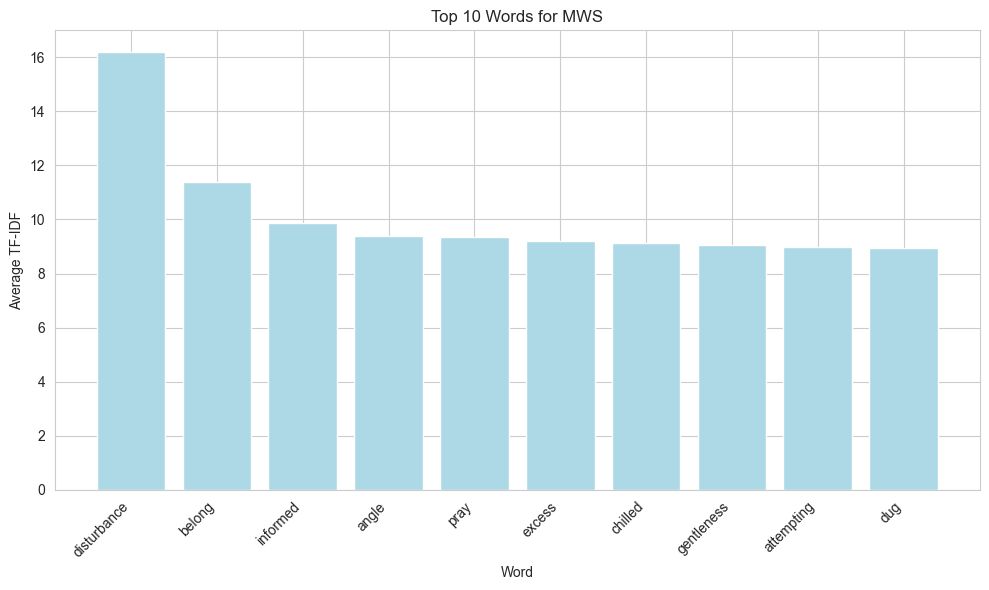

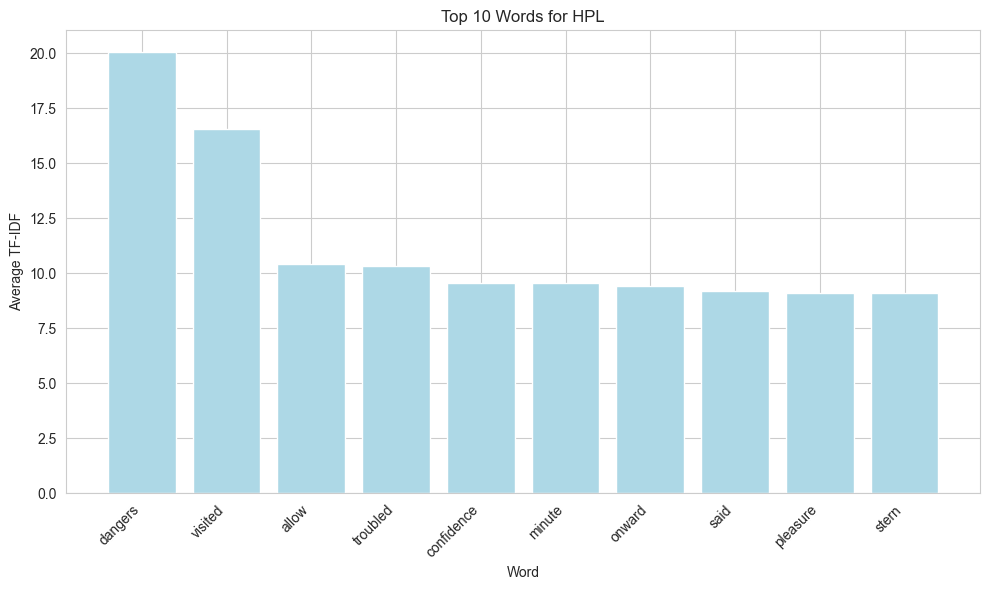

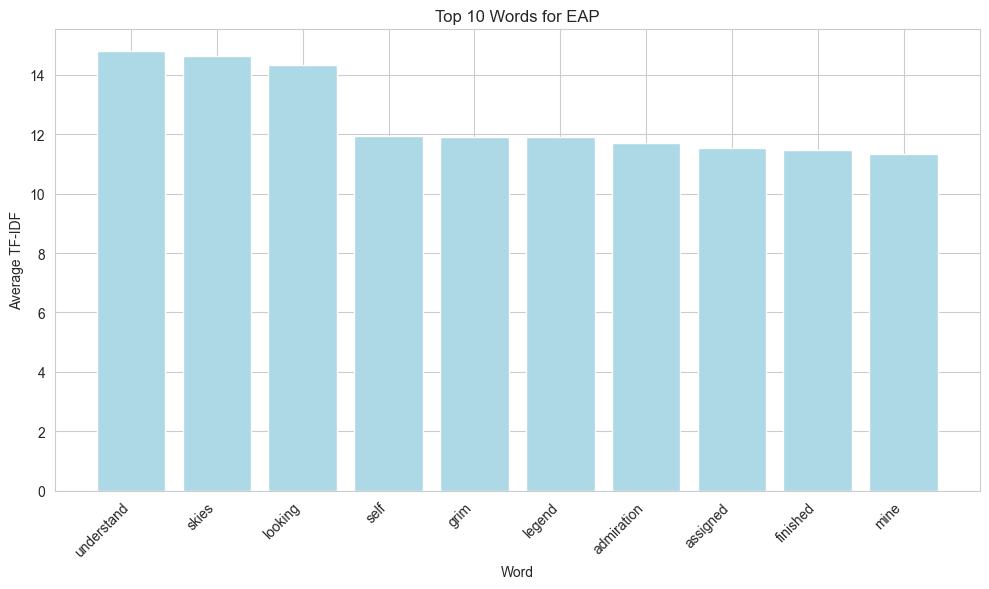

In [6]:
# Stage 2 Visualizations (ex: Most Important Word By Author)
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Redo TFIDF: Need to use CountVectorizer here to retain the words for future analysis
cv = CountVectorizer(inputCol='words', outputCol='tf_cv', minDF=3.0, vocabSize=4096)
cv_model = cv.fit(tf_data_train)
tf_cv_data = cv_model.transform(tf_data_train)
idf_cv = IDF(minDocFreq=3, inputCol='tf_cv', outputCol='tfidf')
idf_cv_model = idf.fit(tf_cv_data)
tfidf_cv_data = idf_cv_model.transform(tf_cv_data).drop('tf_cv')
tfidf_cv_data.cache()

# Here I have to switch to using Pandas, as Spark would have timeout issues when trying to parse the TFIDF dataframe. Since this is just for visualization this should be fine
tfidf_pandas = tfidf_cv_data.select('author', 'tfidf').toPandas()

# Group the tfidf vectors per author
top_words_per_author = defaultdict(list)
for _, row in tfidf_pandas.iterrows():
    author = row['author']
    vector = row['tfidf']
    for index, value in zip(vector.indices, vector.values):
        top_words_per_author[author].append((index, value))

# Now compute the average tfidf value per word per author
avg_tfidf_per_author = {}
vocab = cv_model.vocabulary
for author, terms in top_words_per_author.items():
    # For each term get the sum and counts
    index_sums = defaultdict(lambda: {'sum': 0.0, 'count': 0})
    for index, value in terms:
        index_sums[index]['sum'] += value
        index_sums[index]['count'] += 1
    
    # Now compute the averages
    avg_tfidf = [(vocab[index], data['sum'] / data['count']) for index, data in index_sums.items()]

    # Sort averages by descending average value (element 1 in avg_tfidf above) and get top 10 words
    avg_tfidf = sorted(avg_tfidf, key=lambda x: x[1], reverse=True)[:10]

    # Assign them to the correct author
    avg_tfidf_per_author[author] = pd.DataFrame(avg_tfidf, columns=['word', 'avg(value)'])

# Plot the best words per author
for author, df in avg_tfidf_per_author.items():
    plt.figure(figsize=(10, 6))
    plt.bar(df['word'], df['avg(value)'], color='lightblue')
    plt.xlabel('Word')
    plt.ylabel('Average TF-IDF')
    plt.title(f'Top 10 Words for {author}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

<hr>

### Stage 3 - Machine Learning
1) Perform train/test split
2) Perform algorithmic analysis to assess and predict test labels
    - Use as many algorithms as you need to get a good answer.
    - Supervised: logistic regression, random forest, support vector machines, etc.
    - Unsupervised: K-means, dimensionality reduction, PCA, etc.

In [7]:
# Stage 3 Solution (Due by Monday 7/21)
# Each team member will do 2 algorithms of their choosing

# Train test split for below
train_data, test_data = tfidf_data_train.randomSplit([0.7, 0.3], seed=42)
train_data.cache()
test_data.cache()
print(f"Training set size: {train_data.count()} rows")
print(f"Test set size: {test_data.count()} rows")

Training set size: 13608 rows
Test set size: 5968 rows


In [8]:
# Aidan: Logistic Regression, Agglomerative Heirarchical Clustering

# ---------- Logistic Regression ----------
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Convert author labels to numeric index
indexer = StringIndexer(inputCol='author', outputCol='label')
indexer_model = indexer.fit(train_data)
indexed_train = indexer_model.transform(train_data)
indexed_test = indexer_model.transform(test_data)
indexed_train.cache()
indexed_train.count() # Force the train data to cache

# Define model
lr = LogisticRegression(featuresCol='tfidf', labelCol='label', maxIter=1000)

# Try to tune hyper params
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [1/c for c in [0.1, 1, 10]]) \
    .build()
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    parallelism=4)
cv_model = cv.fit(indexed_train)
lr_model = cv_model.bestModel

# Predict test data and convert numerical labels back to authors
lr_predictions = lr_model.transform(indexed_test)

label_mapping = indexer_model.labels  # Get mapping of indices to author names (e.g., ['EAP', 'HPL', 'MWS'])
lr_predictions = lr_predictions.withColumn("predicted_author",
    col("prediction").cast("integer").cast("string"))  # Convert prediction to string
lr_predictions = lr_predictions.replace(
    to_replace={str(i): label_mapping[i] for i in range(len(label_mapping))},
    subset=["predicted_author"]
)

# Print top 5 predictions
print("---------------- Logistic Regression Predictions ----------------")
lr_predictions.select("clean_text", "author", "label", "prediction").show(5, truncate=False)

# ---------- Agglomerative Heirarchical Clustering (Using Bisecting KMeans) ----------
from pyspark.ml.clustering import BisectingKMeans

# Train the Bisecting KMeans model
bkm = BisectingKMeans(featuresCol='tfidf', k=3, seed=42)
bkm_model = bkm.fit(train_data)

# Cluster predictions on train and test data
bkm_train_predictions = bkm_model.transform(train_data)
bkm_test_predictions = bkm_model.transform(test_data)

# Show sample cluster assignments for training data
print("\n\n---------------- Train Data Cluster Assignments ----------------")
bkm_train_predictions.select("id", "clean_text", "author", "prediction").show(5, truncate=False)

# Show sample cluster assignments for test data
print("\n\n---------------- Test Data Cluster Assignments ----------------")
bkm_test_predictions.select("id", "clean_text", "prediction").show(5, truncate=False)

---------------- Logistic Regression Predictions ----------------
+--------------------------------------------------------------------------------------------------------------------------------------+------+-----+----------+
|clean_text                                                                                                                            |author|label|prediction|
+--------------------------------------------------------------------------------------------------------------------------------------+------+-----+----------+
|soon they became excessively numerous like impious catacombs of nameless menace and their pungent odour of decay grew quite unbearable|HPL   |2.0  |0.0       |
|he looks to number one                                                                                                                |EAP   |0.0  |0.0       |
|the other face may wear off some                                                                                                

In [9]:
# Daniel: K-means
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans

# pca = PCA(k=10, inputCol="tfidf_norm", outputCol="tfidf_norm_pca")

# train_data_pca = pca.fit(train_data).transform(train_data)

# I'd previously attempted to use a PCA, but now with the
# hashingtf feature count being higher, I cannot run.

kmeans = KMeans(k=3,featuresCol='tfidf_norm')

k_means_model = kmeans.fit(train_data)

k_means_result = k_means_model.transform(train_data)

In [10]:
# Daniel: Neural network
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [hashingTF.getNumFeatures(), 50, 12, 6, 6, 3]
#layers = [hashingTF.getNumFeatures(), 25, 6, 3, 3, 3]

# create the trainer and set its parameters
nn_trainer = MultilayerPerceptronClassifier(maxIter=150, layers=layers,stepSize= 0.008, blockSize=200, seed=1234,featuresCol='tfidf_norm',labelCol='label')

nn_pipeline = Pipeline(stages=[
    indexer
    ,nn_trainer
])

# Fit and transform using same pipeline
nn_model = nn_pipeline.fit(train_data)
nn_results = nn_model.transform(train_data)

In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='accuracy'
)

accuracy = evaluator.evaluate(nn_results)
print(f'Training Accuracy: {accuracy:.4f}')

Training Accuracy: 0.8474


In [12]:
# Claudine:  MulticlassClassification and LDA
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline

# Prepare Data
data = tfidf_data_train.select("tfidf_norm", "author")

# Convert author names to label numbers
label_indexer = StringIndexer(inputCol="author", outputCol="label")
indexed_data = label_indexer.fit(data).transform(data)

# Train-test split
train_data, test_data = indexed_data.randomSplit([0.7, 0.3], seed=42)

# Supervised: Multilayer Perceptron
input_size = train_data.select("tfidf_norm").first()[0].size
layers = [input_size, 128, 64, 3]  

mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="tfidf_norm", maxIter=100, layers=layers, blockSize=128, seed=1234)
mlp_model = mlp.fit(train_data)
mlp_predictions = mlp_model.transform(test_data)

# Unsupervised: LDA
lda = LDA(k=3, seed=42, featuresCol="tfidf_norm")
lda_model = lda.fit(tfidf_data_train)
topics = lda_model.describeTopics(10)
topics.show(truncate=False)



+-----+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                |termWeights                                                                                                                                                                                                                       |
+-----+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[131, 3380, 2687, 383, 3081, 3676, 1389, 109, 991, 737]    |[0.002253066858382698, 0.0021549642717594, 0.002

In [13]:
# Radhika: Random Forest, NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train Random Forest Classifier Model
rf = RandomForestClassifier(featuresCol='tfidf', labelCol='label', numTrees=4)
rf_model = rf.fit(indexed_train)
rf_predictions = rf_model.transform(indexed_test) # Predict test data and convert numerical labels back to authors
print("rf_predictions", rf_predictions.head())

# Train Naive Bayes Classifier Model
nb = NaiveBayes(featuresCol='tfidf', labelCol='label', modelType='multinomial') # Initialize Naive Bayes model
nb_model = nb.fit(indexed_train) # Train the model
nb_predictions = nb_model.transform(indexed_test) # Make predictions on the test data
print("nb_predictions", nb_predictions.head())

# Print top 5 predictions
#print("---------------- PCA Predictions ----------------")
#train_pca.select("pca_features").show(5, truncate=False)
#pca_predictions.select("clean_text", "author", "label", "prediction").show(5, truncate=False)

rf_predictions Row(id='id00095', author='HPL', clean_text='soon they became excessively numerous like impious catacombs of nameless menace and their pungent odour of decay grew quite unbearable', tfidf=SparseVector(4096, {193: 5.0379, 294: 5.3388, 520: 4.7346, 892: 5.5254, 976: 4.0532, 1157: 4.5115, 1722: 6.624, 1733: 5.8568, 1899: 6.5499, 2865: 5.1547, 2972: 6.032, 3110: 6.3558, 3458: 3.4206, 3560: 4.1618, 3793: 4.2261}), tfidf_norm=SparseVector(4096, {193: 0.2473, 294: 0.2621, 520: 0.2324, 892: 0.2713, 976: 0.199, 1157: 0.2215, 1722: 0.3252, 1733: 0.2875, 1899: 0.3216, 2865: 0.2531, 2972: 0.2961, 3110: 0.312, 3458: 0.1679, 3560: 0.2043, 3793: 0.2075}), label=2.0, rawPrediction=DenseVector([1.6891, 1.2156, 1.0953]), probability=DenseVector([0.4223, 0.3039, 0.2738]), prediction=0.0)
nb_predictions Row(id='id00095', author='HPL', clean_text='soon they became excessively numerous like impious catacombs of nameless menace and their pungent odour of decay grew quite unbearable', tfidf=Spar

<hr>

### Stage 4 - Evaluation and Visualization
1) Choose a metric strategy to assess algorithmic performance like accuracy, precision, recall, or F1 score
2) Visualize confusion matrix, correlations, and similar
3) Identify important features contributing to classification
4) Write a 2-3 sentence minimum of findings, learnings, and what you would do next

In [14]:
# Stage 4 Solution (Due by Monday 7/21)
# Each team member will evaluate their models

Logistic Regression F1 Score: 0.7001024067235121


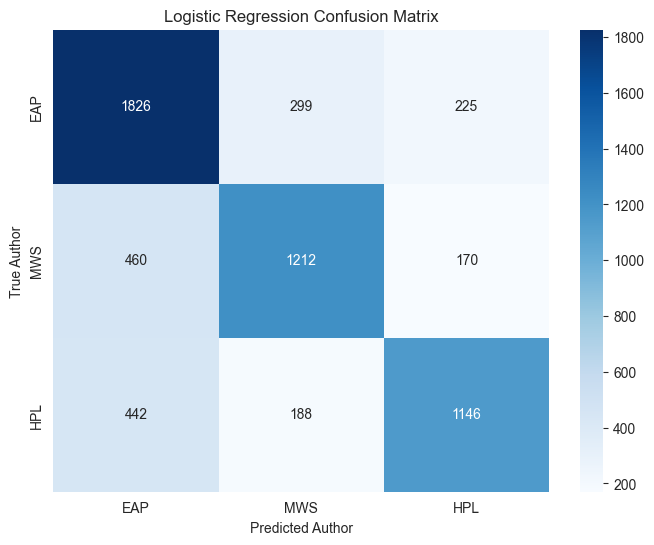

Bisecting K-Means Silhouette Score: -0.019673061092032554
+----------+------+-----+
|prediction|author|count|
+----------+------+-----+
|         0|   MWS| 1972|
|         1|   MWS| 1247|
|         2|   EAP| 1278|
|         2|   HPL| 1151|
|         0|   EAP| 3116|
|         0|   HPL| 1311|
|         2|   MWS|  982|
|         1|   HPL| 1397|
|         1|   EAP| 1154|
+----------+------+-----+



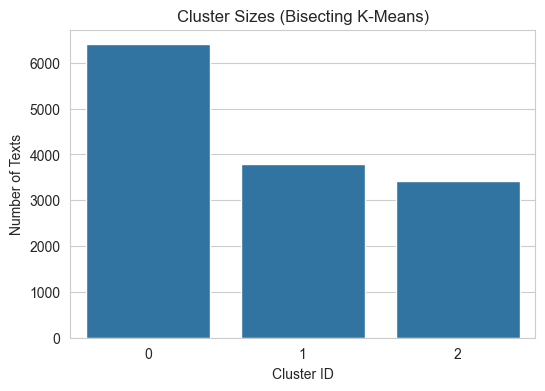

In [15]:
# Aidan
# ---------- Logistic Regression ----------
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression F1 Score: {f1_score}")

# Get confusion matrix
df_lr_predictions = lr_predictions.select('label', 'prediction').toPandas()
conf_mat = confusion_matrix(df_lr_predictions['label'], df_lr_predictions['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Author")
plt.ylabel("True Author")
plt.show()

# ---------- Agglomerative Heirarchical Clustering (Using Bisecting KMeans) ----------
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import count

# Calculate silhouette score
evaluator = ClusteringEvaluator(featuresCol='tfidf', predictionCol='prediction')
silhouette = evaluator.evaluate(bkm_train_predictions)
print(f"Bisecting K-Means Silhouette Score: {silhouette}")

# Map clusters to authors
cluster_author_counts = bkm_train_predictions.groupBy("prediction", "author").agg(count("*").alias("count"))
cluster_author_counts.show()

# Plot cluster sizes
cluster_counts_pd = bkm_train_predictions.groupBy("prediction").count().toPandas()
plt.figure(figsize=(6, 4))
sns.barplot(data=cluster_counts_pd, x="prediction", y="count")
plt.title("Cluster Sizes (Bisecting K-Means)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Texts")
plt.show()

#### Aidan - Logistic Regression and Agglomerative Heirarchical Clustering (Bisecting K-Means)
1) Logistic regression did a good job of predicting the test data with minimal hyper param tuning (only 3 params and 3 folds, so 9 models), but it still only achieved ~70% for its accuracy score
    - Next I would dive into tuning this more in depth and perform a large cross validation with many different params and iteration counts
2) Bisecting K-Means did not perform well. As indicated by it's silhouette score of ~-0.01, the clusters are not well defined and probably overlap significantly.
    - I would not go any further with this algorithm for 2 reasons. It's unsupervised and would require a lot of preprocessing to get a tangible result. Since the data is labeled, a supervised algorithm would be a better fit here as seen by Logistic Regressions accuracy

K-Means Silhouette Score: 0.0006583631811794777
+----------+------+-----+
|prediction|author|count|
+----------+------+-----+
|         0|   MWS|   12|
|         1|   MWS| 1758|
|         0|   EAP|    6|
|         0|   HPL|    2|
|         1|   HPL| 1676|
|         1|   EAP| 2284|
+----------+------+-----+



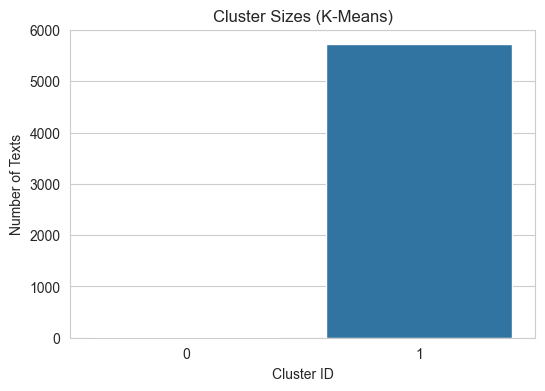

Neural Network Accuracy Score: 0.7972417463473579


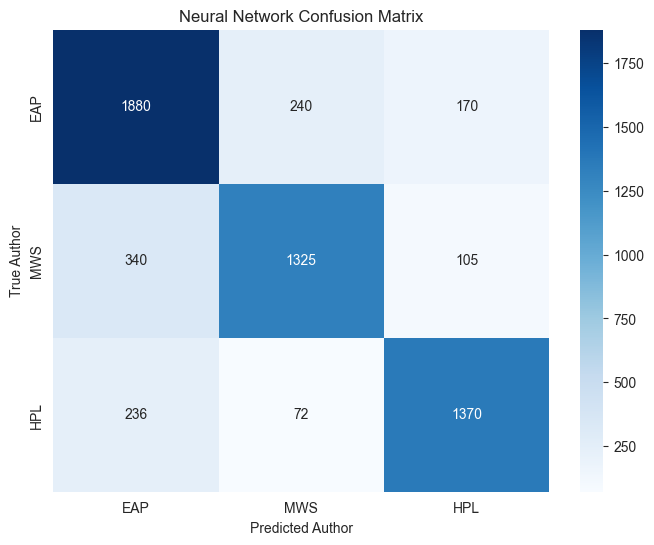

In [17]:
# Daniel
# -----------------   K-means      ---------------------------
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import count

km_test_predictions = k_means_model.transform(test_data)

# Calculate silhouette score
evaluator = ClusteringEvaluator(featuresCol='tfidf_norm', predictionCol='prediction')
silhouette = evaluator.evaluate(km_test_predictions)
print(f"K-Means Silhouette Score: {silhouette}")

# Map clusters to authors
cluster_author_counts = km_test_predictions.groupBy("prediction", "author").agg(count("*").alias("count"))
cluster_author_counts.show()

# Plot cluster sizes
cluster_counts_pd = km_test_predictions.groupBy("prediction").count().toPandas()
plt.figure(figsize=(6, 4))
sns.barplot(data=cluster_counts_pd, x="prediction", y="count")
plt.title("Cluster Sizes (K-Means)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Texts")
plt.show()


# ----------------- Neural Network ---------------------------

test_data_nn = test_data.drop('label')
nn_test_predictions = nn_model.transform(test_data_nn)

nn_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
acc_score = nn_evaluator.evaluate(nn_test_predictions)
print(f"Neural Network Accuracy Score: {acc_score}")

# Get confusion matrix
nn_test_predictions = nn_test_predictions.select('label', 'prediction').toPandas()
nn_conf_mat = confusion_matrix(nn_test_predictions['label'], nn_test_predictions['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(nn_conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Author")
plt.ylabel("True Author")
plt.show()

#### Daniel Lillard Analysis - K means, MultilayerPerceptronClassifier

1. K means: This algorithm ended up doing very poorly, it grouped all the text into one single cluster, there would have to be some feature engineering done, I had tried to do a PCA, however we had to reduce the TF number of features. We would have to find a way to explode the differences between authors for this to be viable.

2. MultilayerPerceptronClassifier: It seems that this is a neural network. I used Keras in a previous class and found it easier to work with then this, I suppose that Spark really does make things harder! I was able to get around a 70% accuracy with minimal effort, NN's are good function approximators and I know can *theoretically* solve for any function. Some feature engineering and hyper-parameter tuning should make this model viable, unlike k-means.

In [ ]:
# Claudine: Stage 4 Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# MLP Classifier
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.evaluate(mlp_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(mlp_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(mlp_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(mlp_predictions, {evaluator.metricName: "f1"})

print("Multilayer Perceptron Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
conf_matrix_df = mlp_predictions.select("label", "prediction").toPandas()
conf_matrix = pd.crosstab(conf_matrix_df["label"], conf_matrix_df["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.tight_layout()
plt.show()

# LDA Topic Interpretation
# Show top 10 term indices and term weights for each topic
print("Top 10 Words per Topic from LDA Model:")
topics.show(truncate=False)

print("LDA Evaluation Metrics:")
print("Log Likelihood:", lda_model.logLikelihood(tfidf_data_train))
print("Perplexity:", lda_model.logPerplexity(tfidf_data_train))

# Convert topics to Pandas DataFrame for heatmap
topic_words_df = topics.toPandas()

# heatmap of term weights
term_matrix = pd.DataFrame(topic_words_df['termWeights'].to_list(), 
                           index=[f"Topic {i}" for i in topic_words_df['topic'].tolist()])
term_matrix.columns = [f"Word {i+1}" for i in range(term_matrix.shape[1])]

plt.figure(figsize=(10, 6))
sns.heatmap(term_matrix, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("LDA Term Weights per Topic")
plt.ylabel("Topics")
plt.xlabel("Top Words")
plt.tight_layout()
plt.show()


#### Claudine - Neural Network and LDA
I used accuracy, precision, recall, and F1 score to evaluate the Multilayer Perceptron, which hit over 71% accuracy. The confusion matrix showed good performance in classifying authors. For LDA, I used log likelihood and perplexity to assess topic quality and reviewed the top words per topic. TF-IDF weights helped identify the most influential words in classification and topic grouping. Next, I’d try tuning MLP hyperparameters and adding features like sentence length or punctuation to see if they improve performance

In [ ]:
# Radhika
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# ------------------------- Random Forest ----------------------
accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

print("Random Forest Algorithm Performance Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Get confusion matrix
df_rf_predictions = rf_predictions.select('label', 'prediction').toPandas()
conf_matx = confusion_matrix(df_rf_predictions['label'], df_rf_predictions['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matx, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Author")
plt.ylabel("True Author")
plt.show()

# The confusion matrix for the random forest is very much skewed towards author Edgar Allen Poe. Also, the accuracy for this algorithm is <50%.
# This indicates that this algorithm is not well-suited to this data, and I think this is because it is a classification problem.

# ------------------------- Naive Bayes ----------------------
accuracy = evaluator.evaluate(nb_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(nb_predictions, {evaluator.metricName: "f1"})

print("Naive Bayes Algorithm Performance Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Get confusion matrix
df_nb_predictions = nb_predictions.select('label', 'prediction').toPandas()
conf_matx = confusion_matrix(df_nb_predictions['label'], df_nb_predictions['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matx, annot=True, fmt='d', cmap='Reds', xticklabels=label_mapping, yticklabels=label_mapping)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Author")
plt.ylabel("True Author")
plt.show()

# The confusion matrix for naive bayes, on the other hand, is very well balanced. Also, the accuracy for this algorithm is naturally
# quite high, indicating that this algorithm is very well-suited to this data. I think this is also because it is a classification problem.

#### Radhika - Random Forest and Naive-Bayes
1) Random Forest: The confusion matrix for the random forest is very much skewed towards author Edgar Allen Poe. Also, the accuracy for this algorithm is <50%. This indicates that this algorithm is not well-suited to this data, and I think this is because it is a classification problem.

2) Naive-Bayes: The confusion matrix for naive bayes, on the other hand, is very well balanced. Also, the accuracy for this algorithm is naturally quite high, indicating that this algorithm is very well-suited to this data. I think this is also because it is a classification problem.